# Предсказание риска ДТП

Целью проекта является создание для каршеринговой компании системы, оценивающей риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства (как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска, если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту).

Для работы заказчиком предложено использоватьследующие данные:
-  период - данные за 2012 год;
-  факты ДТП, повлекшие любые повреждениям транспортного средства кроме типа SCRATCH (царапина);
-  тип виновника — только машина (car);
-  обязательное условие — учесть фактор возраста автомобиля.


## Подключение к базе. Загрузка таблиц sql

Импортируем необходимык библиотеки

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import catboost as cb
import warnings
warnings.filterwarnings('ignore')

from sqlalchemy import create_engine 

from numpy.random import RandomState

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler,  OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn. metrics import precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector

from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from math import ceil, sqrt

from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier

Подключаемся к базе данных

In [5]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 
  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [6]:
engine = create_engine(connection_string) 

## Первичное исследование таблиц

Создаем запросы по каждой таблице к базе данных.

In [7]:
query = '''
SELECT *
FROM Vehicles; 

'''

vehicles = pd.read_sql_query(query, con=engine) 
vehicles

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0
...,...,...,...,...,...,...
1021229,1175684,5304990,2,sedan,manual,6.0
1021230,1175686,5304993,2,sedan,manual,3.0
1021231,1175687,5304994,2,sedan,manual,3.0
1021232,1175693,5305002,1,sedan,manual,5.0


In [8]:
query = '''
SELECT *
FROM Parties; 

'''

parties = pd.read_sql_query(query, con=engine) 
parties

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
...,...,...,...,...,...,...,...,...,...
2752403,1549682,4981212,2,building,0,22.0,had not been drinking,None,NaN
2752404,1644472,5041069,2,building,0,13.0,had not been drinking,None,0.0
2752405,1906386,5181692,1,building,1,5.0,had not been drinking,None,0.0
2752406,2403824,5453437,2,building,0,30.0,had not been drinking,None,0.0


In [9]:
query = '''
SELECT *
FROM collisions; 

'''
collisions = pd.read_sql_query(query, con=engine) 
collisions

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399995,4082805,1502,kern,57.0,east,0.0,clear,None,middle damage,2,vehicle code violation,pedestrian violation,other,other object,dry,normal,dark with no street lights,none,2009-01-17,21:04:00
1399996,4082820,1953,los angeles,0.0,None,1.0,clear,None,middle damage,2,vehicle code violation,pedestrian right of way,other,other object,dry,normal,daylight,functioning,2009-01-18,14:20:00
1399997,4082829,1502,kern,0.0,None,1.0,clear,highway,middle damage,2,vehicle code violation,pedestrian right of way,other,other object,dry,normal,dark with street lights,functioning,2009-01-17,18:06:00
1399998,4083008,4313,santa clara,20.0,east,NaN,clear,None,middle damage,2,vehicle code violation,pedestrian right of way,other,other object,dry,normal,dark with street lights,functioning,2009-01-06,17:53:00


In [10]:
query = '''
SELECT *
FROM case_ids ;

'''
case_ids = pd.read_sql_query(query, con=engine) 
case_ids

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
...,...,...
1399995,5668365,2021
1399996,5668366,2021
1399997,5668367,2021
1399998,5668368,2021


Предоставленные заказчиком данные представляют собой 4 таблицы, соединенные общим ключем case_id. В таблице "case_ids" отсутствуют данные, за исключением идентификатора ДТП и номера года, который, по всей видимости, является годом выгрузки базы.

В описании проекта указано, что под риском понимается вероятность ДТП с оговоренными повреждениями транспортного средства.  

Вместе с тем, как следует из описания проекта, заказчиком избрано целевое значение — at_fault (виновник) в таблице parties), что несколько противоречит идее предсказания ДТП, поскольку по такому целевому признаку можно предсказать виновен/не виновен, а не ДТП/не ДТП. Для предсказания же самого факта ДТП необходимы данные обо всех поездках (которых у нас нет), а не только об аварийных (которые предоставлены для проекта).

В этой связи представляется более правильным переформулировать задачу - создать модель машинного обучения, предсказывающую, насколько "рискованным" для каршеринговой компании окажется клиент, как только он сел за руль автомобиля и выбрал маршрут.


В самих таблицах и описании их данных есть небольшие несоответствия, в связи с чем необходимо додумывать смысл значений. Так, в описании таблицы "collisions" имеются сведения о столбце "CONTROL_CONDITION_1" (устройство управления), фактически этот столбец называется "control_device" и нет данных о каком именно устройстве идет речь. В этой же таблице (столбец PCF_VIOLATION_CATEGORY) имеется значение dui, которого, на первый взгляд, нет в описании данных и потребовалось дополнительно выяснять что это аббревиатура переводится как "состояние алкогольного опьянения". 

##  Статистический анализ факторов ДТП

Статистический анализ факторов ДТП (за весь период) построим следующим образом:
-  в соответствии с условием проекта выясним, в какие месяцы происходит наибольшее количество аварий, для вычислений используем таблицу collisions и составим диаграмму;
-  создадим аналитические задачи по двум из которых напишем решение и сделаем выводы.


In [11]:
query = '''
SELECT DISTINCT 
       EXTRACT(YEAR FROM collision_date) year_collisions, 
       EXTRACT(MONTH FROM collision_date) month_collisions,
       count(case_id) OVER (PARTITION BY EXTRACT(YEAR FROM collision_date),EXTRACT(MONTH FROM collision_date)) 
       
FROM collisions
'''
month_year = pd.read_sql_query(query, con=engine)
month_year.head()

,year_collisions,month_collisions,count
0,2009.0,1.0,35062
1,2009.0,2.0,34480
2,2009.0,3.0,36648
3,2009.0,4.0,35239
4,2009.0,5.0,36916


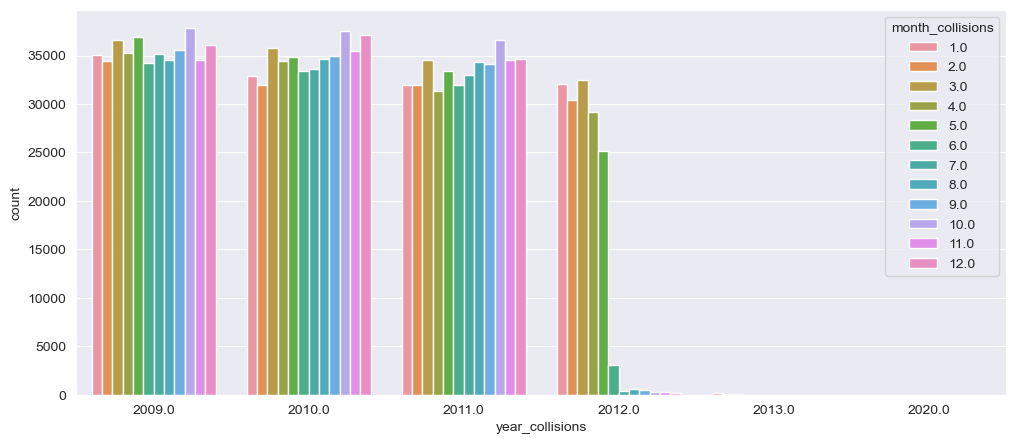

In [12]:
plt.figure(figsize=[12,5])
sns.set_style("darkgrid")
sns.barplot(x="year_collisions", y="count", hue="month_collisions", data=month_year);

In [13]:
month_year = month_year.pivot("year_collisions", "month_collisions", "count")
month_year

month_collisions,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
year_collisions,,,,,,,,,,,,
2009.0,35062.0,34480.0,36648.0,35239.0,36916.0,34202.0,35161.0,34508.0,35555.0,37835.0,34562.0,36060.0
2010.0,32892.0,31918.0,35803.0,34416.0,34862.0,33367.0,33645.0,34620.0,34957.0,37480.0,35460.0,37070.0
2011.0,31926.0,31975.0,34585.0,31377.0,33370.0,31962.0,33029.0,34339.0,34137.0,36618.0,34495.0,34615.0
2012.0,32020.0,30377.0,32498.0,29143.0,25168.0,3062.0,390.0,622.0,510.0,304.0,253.0,200.0
2013.0,144.0,108.0,46.0,5.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2020.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN



<b> Вывод:</b> В таблицах, представленных заказчиком, наиболее полно представлены данные за 2009-2011 годы. В 2012 году наиболее полной представляется информация за первые 5 месяцев, начиная с июня цифровые показатели стремительно снижаются, что говорит о неполноте данных. В 2013 году информация отрывочна - всего лишь за 5 месяцев из 12 и то не по порядку, в 2020 год каким-то образом (скорее всего случайно) попали данные о 2 ДТП (суммарно). 
    
Что касается данных об аварийности по месяцам, то пик аварий во всех трех периодах с полными данными приходится на октябрь. Также весьма аварийными являются март и май. Вообще аварийность не сильно колеблется в течение года: не опускается ниже 31000 и не поднимается выше 38000 (там, где данные полные). 

<b> Аналитическими задачами определим следующие:</b>
-  изучение данных, характеризующих поведение виновных в ДТП лиц (написано решение);
-  изучение данных о техническом состоянии автомобилей, побывавших в аварии (написано решение);
-  влияние внешних факторов (дорожное состояние, освещенность, погодные условия) на аварийность;
-  соотнесение наиболее аварийных сочетаний день недели-время суток (построить тепловую карту)
-  анализ локализованности ДТП по географическим регионам, типам дорог (построить графики, либо тепловую карту);
-  проанализировать роль пешеходов в ДТП. 

### Изучение данных о виновном лице

Для изучения данных, характеризующих поведение виновников ДТП, необходимо получить следующие статистические данные (с обязательным условием at_fault = 1):   
-  соотнести количество ДТП с количеством лиц, виновных в них;
-  изучить распределение типов аварий;
-  получить данные об основных факторах аварий, в которых установлены виновные лица; 
-  вывести данные о 10 наиболее частых категориях нарушений ПДД, допущенных виновниками ДТП (таблица должна содержать наименование категории нарушения ПДД, количество);
-  получить данные о наиболее распространенных сочетаниях пар: нарушение ПДД - тип аварии, построить тепловую карту;
-  проанализировать распространенность по регионам случаев ДТП, когда виновные лица садились за руль будучи выпившими (находился под влиянием алкоголя; был пьян, не под влиянием алкоголя; был пьян, ухудшение неизвестно); вэтой связи вывести названия 10 географических регионов, в которых произошло наибольшее количество ДТП участники которых выпивали,вывести долю таких лиц от общего количества виновников ДТП
-  изучить серьезность повреждений для автомобиля в зависимости от состояния виновного участника ДТП когда он выпивал (находился под влиянием алкоголя; был пьян, не под влиянием алкоголя; был пьян, ухудшение неизвестно) и когда он не пил.

Сравниваем количество ДТП и число виновников аварий

In [14]:
query = '''
WITH
n AS
(SELECT case_id,
       count(at_fault) OVER () AS sum_fault
FROM parties
where at_fault = 1),
nn AS (SELECT case_id,
       count(case_id) OVER () AS count_case
       FROM collisions)
       
SELECT DISTINCT nn.count_case,
       n.sum_fault,
       nn.count_case - n.sum_fault AS difference
FROM n 
LEFT OUTER JOIN nn ON n.case_id = nn.case_id  
''' 
c43 = pd.read_sql_query(query, con=engine) 

In [15]:
c43

,count_case,sum_fault,difference
0,1400000,1288127,111873


Количество ДТП превышает количество виновных лиц на 111873. Это может означать, что не по всем авариям установлены виновные лица.

Получаем данные о типах аварий, по которым установлены виновные лица.

In [16]:
query = '''
SELECT col.type_of_collision,
       count(col.case_id) as count_type_collision

FROM collisions as col
LEFT OUTER JOIN parties as par on par.case_id = col.case_id   
where par.at_fault = 1
group by col.type_of_collision
order by count_type_collision desc
''' 
c45 = pd.read_sql_query(query, con=engine) 

,type_of_collision,count_type_collision
0,rear end,450359
1,broadside,246492
2,sideswipe,214660
3,hit object,210119
4,other,64357
5,head-on,54902
6,overturned,37422
7,None,9816


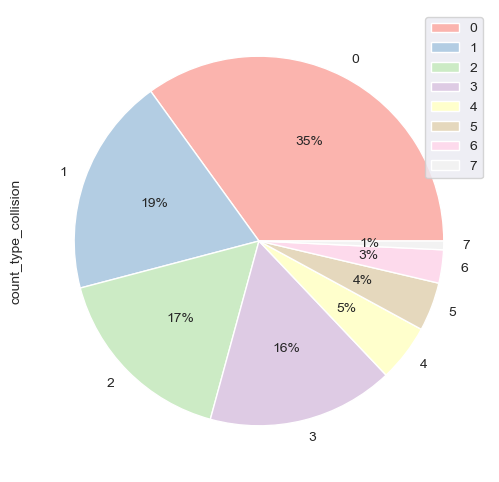

In [17]:
ax = c45.plot(kind='pie', y='count_type_collision', autopct='%1.0f%%', cmap = "Pastel1",figsize=(6, 6))
c45

Наибольшее количество аварий (35%) связаны со столкновением задней частью, на втором месте (19%) - боковой удар, по 17% аварии являются ударами объектов и других сторон.

Получаем данные об основных факторах аварий, по которым установлены виновные лица

In [18]:
query = '''
SELECT DISTINCT col.primary_collision_factor,
       count(*) OVER (PARTITION BY col.primary_collision_factor) AS count_collision_factor,
       ROUND(((count(*) OVER (PARTITION BY col.primary_collision_factor))*100.0/(count(*) OVER ())),3) AS part_collision_factor
FROM collisions as col
LEFT OUTER JOIN parties as par on par.case_id = col.case_id   
where par.at_fault = 1

''' 
c42 = pd.read_sql_query(query, con=engine) 

In [19]:
c42 

,primary_collision_factor,count_collision_factor,part_collision_factor
0,vehicle code violation,1281583,99.492
1,other improper driving,6497,0.504
2,fell asleep,47,0.004


В 99,5% случаев осовным фактором аварии является нарушение виновными правил дорожного движения, установим количество каждого вида нарушения в порядке убывания. 

Выводим данные о 10 наиболее частых категориях нарушений ПДД, допущенных виновниками ДТП. 

In [20]:
query = '''
WITH n AS
(SELECT col.case_id as c,
        par.case_id as pa,
        col.primary_collision_factor,
       par.at_fault,
       col.pcf_violation_category       
FROM collisions as col
LEFT OUTER JOIN parties as par on par.case_id = col.case_id 
where col.primary_collision_factor = 'vehicle code violation'
and par.at_fault = 1)
SELECT pcf_violation_category,
       count(at_fault) as count_violation
FROM n
group by  pcf_violation_category
order by count_violation desc
limit 10
''' 
c4 = pd.read_sql_query(query, con=engine) 

,pcf_violation_category,count_violation
0,speeding,433379
1,improper turning,233834
2,automobile right of way,154852
3,dui,108727
4,unsafe lane change,87987
5,traffic signals and signs,65819
6,unsafe starting or backing,54339
7,wrong side of road,32776
8,following too closely,29398
9,None,17542


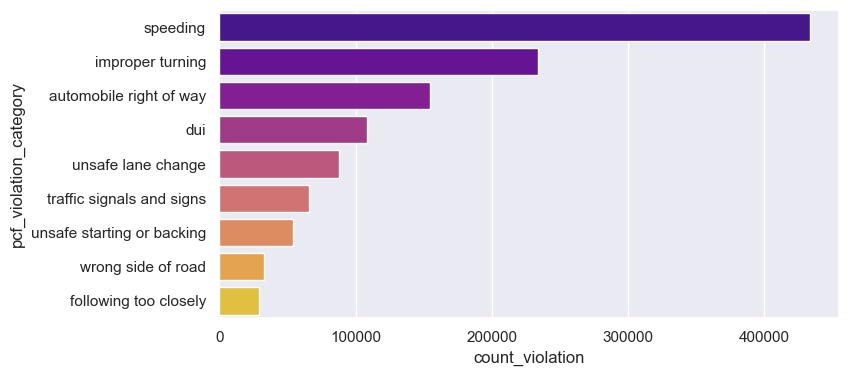

In [21]:
plt.figure(figsize=[8,4])
sns.set (font_scale= 1 )
ax = sns.barplot(x='count_violation', y="pcf_violation_category", data=c4, palette='plasma')
c4

Самое распространенное нарушение ПДД, допущенное виновниками ДТП, является неправильный выбор скоростного режима (speeding) - 433379, следующим по распространенности является неправильный поворот (improper turning) - 233834 и замыкает тройку нарушение права приоритетного проезда (automobile right of way) - 154852.

Найдем наиболее распространенные сочетания пар: нарушение ПДД - тип аварии. Для наглядности построим тепловую карту.

In [22]:
query = '''
WITH n AS
(SELECT col.type_of_collision,
       col.pcf_violation_category       
FROM collisions as col
LEFT OUTER JOIN parties as par on par.case_id = col.case_id 
where col.primary_collision_factor = 'vehicle code violation'
and par.at_fault = 1
and col.type_of_collision is not null
and col.pcf_violation_category is not null)

SELECT DISTINCT pcf_violation_category,
                type_of_collision,
       count(type_of_collision) OVER (PARTITION BY pcf_violation_category, type_of_collision) AS count_type_collision
FROM n
''' 
c44 = pd.read_sql_query(query, con=engine) 

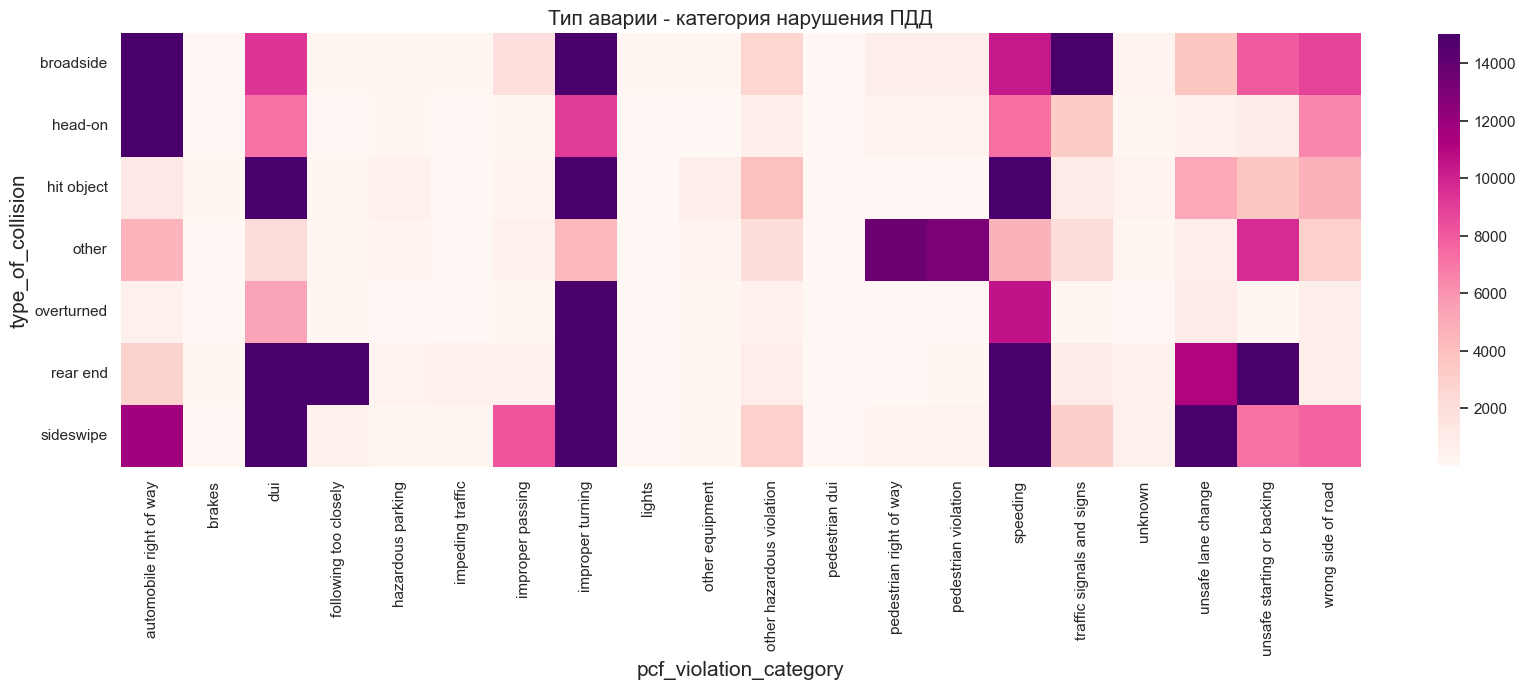

In [23]:
c44 = c44.pivot("type_of_collision", "pcf_violation_category", "count_type_collision")
c44.fillna(0, inplace=True)

fig, ax = plt.subplots(figsize=(20, 8) )
ax = sns.heatmap(c44,  vmin=10, vmax=15000, linecolor='w',  cbar_kws={"shrink": 0.7},
                cmap="RdPu" ,square=True)

plt.xlabel('pcf_violation_category', fontsize= 15); 
plt.ylabel('type_of_collision', fontsize= 15); 
ax=plt.title('Тип аварии - категория нарушения ПДД', fontsize= 15) 

Среди наиболее часто встречающихся сочетаний нарушений виновниками ПДД и типов аварий можно выделить следующие:   
-  нарушение права преимущественного проезда -  столкновение "лоб в лоб", боковой удар;
-  вождение в состоянии алкогольного опьянения - боковой удар, столкновение задней частью, удар объекта;
-  несоблюдение дистанции -  удар в заднюю часть автомобиля;
-  неправильный поворот - все типы аварий, кроме лобового столкновения и типов, обозначенных как "другие";
-  выбор неоптимальной скорости движения - столкновение с объектами, удары различными сторонами и повреждение задней части автомобиля;
-  нарушения дорожных знаков и сигналов - боковые удары;
-  небезопасная смена полосы движения - боковоц удар;
-  опасный старт - повреждение задней части автомобиля.

Для анализа распространенности по регионам случаев ДТП, когда виновные лица садились за руль будучи выпившими, выведем  названия 10 географических регионов, в которых произошло наибольшее количество ДТП участники которых выпивали(находился под влиянием алкоголя; был пьян, не под влиянием алкоголя; был пьян, ухудшение неизвестно).

In [24]:
query = '''
WITH n AS
(SELECT  col.county_location,
        par.party_sobriety    
FROM collisions as col
LEFT OUTER JOIN  parties as par on  par.case_id = col.case_id 
WHERE par.party_sobriety IN ('had been drinking, under influence',
                       'had been drinking, impairment unknown',
                       'had been drinking, not under influence')
AND par.at_fault = 1)                       
                       SELECT county_location,
                              count(party_sobriety) as had_been_drinking
                       FROM n
                       group by county_location 
                       order by had_been_drinking desc
limit 10
'''                       
c16 = pd.read_sql_query(query, con=engine) 

In [25]:
c16

,county_location,had_been_drinking
0,los angeles,35405
1,orange,11808
2,san diego,9722
3,san bernardino,7600
4,riverside,7243
5,alameda,5035
6,sacramento,4976
7,santa clara,4231
8,kern,3626
9,ventura,3324


Выводим долю виновных в ДТП, которые садились за руль будучи выпившими от общего количества виновников. Данную информацию сформируем по регионам в порядке убывания доли выпивших. 

In [26]:
query = '''
WITH 

y1 AS (WITH
n AS (SELECT  col.county_location,
        par.party_sobriety    
FROM collisions as col
LEFT OUTER JOIN  parties as par on  par.case_id = col.case_id 
WHERE par.party_sobriety IN ('had been drinking, under influence',
                       'had been drinking, impairment unknown',
                       'had been drinking, not under influence')
AND par.at_fault = 1)                       
                       SELECT county_location,
                              count(party_sobriety) as had_been_drinking
                       FROM n
                       group by county_location 
                       order by had_been_drinking desc),
y2 AS (WITH
nn AS (SELECT  col.county_location,
        par.party_sobriety,
        count(par.party_sobriety) OVER (PARTITION BY col.county_location) AS count_party
FROM collisions as col
LEFT OUTER JOIN  parties as par on  par.case_id = col.case_id 
WHERE par.at_fault = 1)
SELECT DISTINCT county_location, 
       count_party
FROM nn)

SELECT y1.county_location,
       y1.had_been_drinking,
       y2.count_party,
       y1.had_been_drinking*100 /count_party AS part
FROM y1 INNER JOIN y2 ON y1.county_location = y2.county_location       
ORDER BY part DESC
LIMIT 10
'''                       
c17 = pd.read_sql_query(query, con=engine) 

In [27]:
c17

,county_location,had_been_drinking,count_party,part
0,trinity,118,595,19
1,butte,1021,5614,18
2,lake,357,1931,18
3,el dorado,865,5018,17
4,modoc,43,286,15
5,madera,746,4939,15
6,mendocino,505,3361,15
7,humboldt,877,6047,14
8,sierra,29,197,14
9,napa,684,4622,14


На первый взгляд лидерами по вождению после употребления алкоголя являются такие округа как как los angeles, orange, san diego. Но ни один из топ 10 округов по количеству "выпивох" не вошел в топ 10 населенных пунктов, в которых высокая доля таких лиц в общем количестве виновников ДТП. 	

Изучаем серьезность повреждений для автомобиля в зависимости от состояния виновного участника ДТП когда он выпивал (находился под влиянием алкоголя; был пьян, не под влиянием алкоголя; был пьян, ухудшение неизвестно) и когда он не пил.

In [28]:
query = '''
WITH n AS
(SELECT par.case_id as pa, 
        col.collision_damage,
        par.at_fault, 
         CASE
   WHEN par.party_sobriety = 'had been drinking, under influence' THEN 'drinking'
   WHEN par.party_sobriety = 'had been drinking, impairment unknown' THEN 'drinking'
   WHEN par.party_sobriety = 'had been drinking, not under influence' THEN 'drinking'
   WHEN par.party_sobriety = 'had not been drinking' THEN 'not_drinking'
END party_sobriety
        
FROM collisions as col
LEFT OUTER JOIN  parties as par on  par.case_id = col.case_id
where par.at_fault = 1
and par.party_sobriety IN ('had been drinking, under influence',
                            'had been drinking, impairment unknown',
                            'had been drinking, not under influence',
                           'had not been drinking'))
SELECT DISTINCT 
                party_sobriety,
                collision_damage,
      count( collision_damage) OVER (PARTITION BY collision_damage, party_sobriety) AS count_party
     
FROM n

''' 
c7 = pd.read_sql_query(query, con=engine)

In [29]:
c74 = c7.pivot("party_sobriety", "collision_damage", "count_party")
c74

collision_damage,fatal,middle damage,scratch,severe damage,small damage
party_sobriety,,,,,
drinking,3700,24991,20141,6957,79153
not_drinking,5013,115380,270466,17756,520205


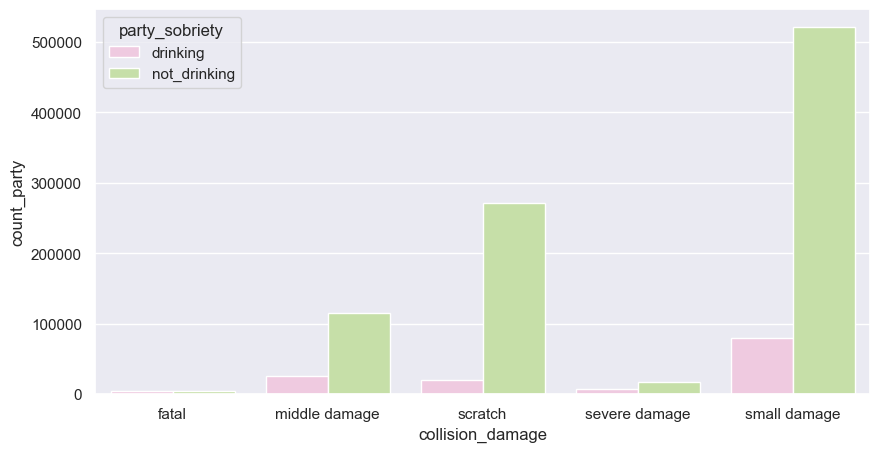

In [30]:
plt.figure(figsize=[10,5])
sns.set_style("darkgrid")
sns.barplot(x="collision_damage", y="count_party", hue="party_sobriety", data=c7, palette='PiYG');

При любом виде повреждения автомобиля, явившегося следствием ДТП, количество виновников аварии, садившихся за руль выпившими, знаительно меньше тех, кто не пил вовсе. Но это не значит, что те, кто выпивает, реже становится виновником ДТП. Логика подсказывает, что скорее наоборот (это предмет отдельного анализа для которого нужны данные обо всех поездках, а не только об аварийных), просто трезвые гораздо чаще садятся за руль (а значит и попадают в ДТП) чем те, кто выпил.

Вместе с тем, можно заметить, что чем серьезнее повреждение автомобиля, тем меньше разница в количестве выпивавших и не вывивавших виновниках ДТП.


<b> Вывод:</b> Изучением ДТП, по которым известны виновные, установлено следующее.
    
Количество ДТП превышает количество виновных лиц на 111873. Это может означать, что по части ДТП  виновные лица не установлены.
    
Наибольшее количество аварий (35%) связаны со столкновением задней частью, на втором месте (19%) - боковой удар, 17% аварий являются ударами объектов и других сторон.
    
В 99,5% случаев осовным фактором аварии является нарушение виновными правил дорожного движения.
    
Самое распространенное нарушение ПДД, допущенное виновниками ДТП, является неправильный выбор скоростного режима (speeding) - 433379, неправильный поворот (improper turning) - 233834 и замыкает тройку нарушение права приоритетного проезна (automobile right of way) - 154852.
    
Среди наиболее часто встречающихся сочетаний нарушений виновниками ПДД и типов аварий можно выделить следующие:
нарушение права преимущественного проезда - столкновение "лоб в лоб", боковой удар; вождение в состоянии алкогольного опьянения - боковой удар, столкновение задней частью, удар объекта;
несоблюдение дистанции - удар в заднюю часть автомобиля;
неправильный поворот - все типы аварий, кроме лобового столкновения и типов, обозначенных как "другие";
выбор неоптимальной скорости движения - столкновение с объектами, удары различными сторонами и повреждение задней части автомобиля;
нарушения дорожных знаков и сигналов - боковые удары;
небезопасная смена полосы движения - боковоц удар;
опасный старт - повреждение задней части автомобиля.    

На первый взгляд лидерами по вождению после употребления алкоголя являются такие округа как как los angeles, orange, san diego. Но ни один из топ 10 округов по количеству "выпивох" не вошел в топ 10 населенных пунктов, в которых высокая доля таких лиц в общем количестве виновников ДТП.
    
При любом виде повреждения автомобиля, явившегося следствием ДТП, количество виновников аварии, садившихся за руль выпившими, значительно меньше тех, кто не пил вовсе. Вместе с тем, можно заметить, что чем серьезнее повреждение автомобиля, тем меньше разница в количестве выпивавших и не вывивавших виновниках ДТП.
</div>  

### Изучение данных о техническом состоянии автомобилей, побывавших в аварии

-  посчитать количество автомобилей, побывавших в аварии;
-  проанализировать распределение автомобилей, побывавших в аварии в зависимости от типа кузова и коробки передач;
-  проанализировать распределение автомобилей по возрасту, построить график;
-  сопоставить  серьезность повреждений в результате ДТП с возрастом машин.

Считаем количество автомобилей, побывавших в аварии.

In [31]:
query = '''
SELECT count(id)
FROM Vehicles

'''
c05 = pd.read_sql_query(query, con=engine) 

In [32]:
c05

,count
0,1021234


Всего в данных имеются сведения о 1021234 автомобилях каршеринговой компании, побывавших в аварии.

Группируем данные в зависимости от типа кузова автомобилей и коробки передач.

In [33]:
query = '''
SELECT vehicle_type,
       count(id)
FROM Vehicles
group by vehicle_type
'''
c02 = pd.read_sql_query(query, con=engine) 


query = '''
SELECT vehicle_transmission,
       count(id)
FROM Vehicles
group by vehicle_transmission
'''
c03 = pd.read_sql_query(query, con=engine) 


In [34]:
display(c02)
display(c03)

,vehicle_type,count
0,coupe,442780
1,hatchback,45595
2,minivan,43000
3,other,1194
4,sedan,488665


,vehicle_transmission,count
0,auto,502243
1,manual,495332
2,None,23659


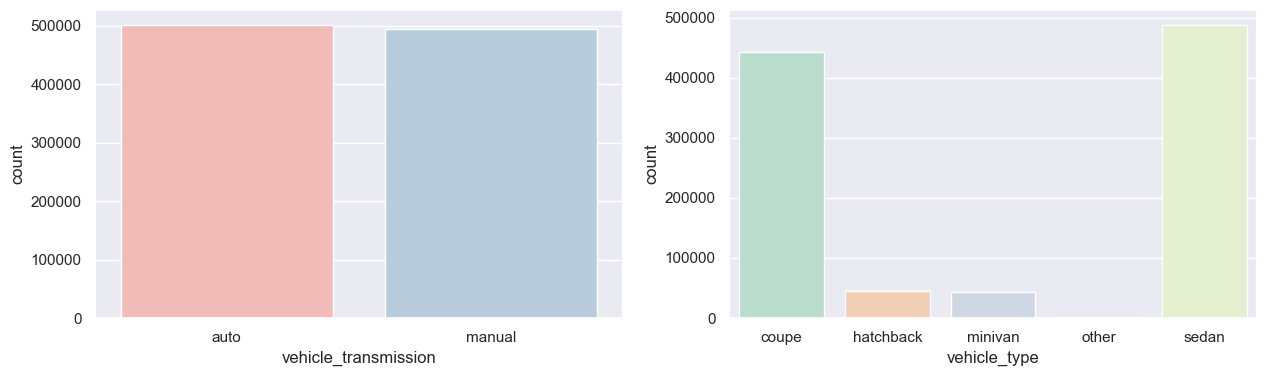

In [35]:
f, axes = plt.subplots(1,2)
f.set_size_inches(15, 4)
ax =sns.barplot(  y="count", x= "vehicle_transmission", data=c03, ax=axes[0],palette='Pastel1' )
ax = sns.barplot(  y= "count", x= "vehicle_type", data=c02, ax=axes[1], palette='Pastel2')

Количество автомобилей с автоматической коробкой передач примерно совпадает с количеством машин с ручной коробкой передач (около 500 тыс.), по 23,6 тыс. автомобилей тип коробки передач неизвестен.

Узнаем распределение автомобилей по возрасту.

In [36]:
query = '''
SELECT vehicle_age,
       count(id)  AS count_age     
FROM Vehicles
group by vehicle_age

'''
count_age = pd.read_sql_query(query, con=engine) 
count_age

,vehicle_age,count_age
0,0.0,40262
1,1.0,41307
2,2.0,106530
3,3.0,178550
4,4.0,125472
5,5.0,105035
6,6.0,84362
7,7.0,84282
8,8.0,77070
9,9.0,58255


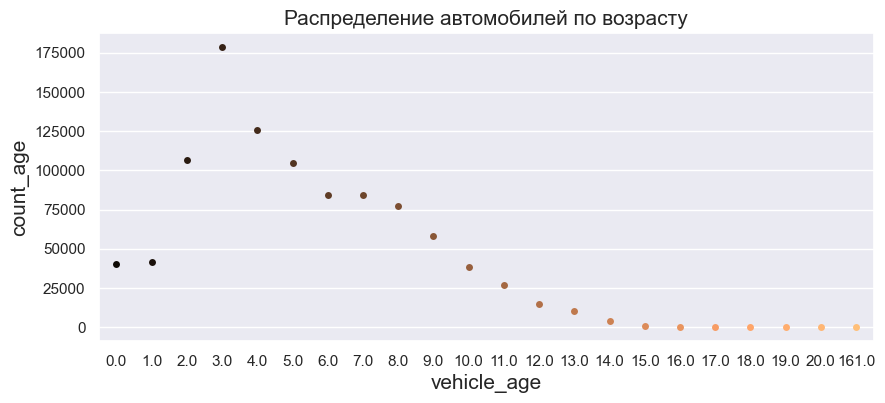

In [37]:
plt.figure(figsize=[10,4])
ax =sns.swarmplot(x ='vehicle_age', y ="count_age",data = count_age, palette='copper')
plt.xlabel('vehicle_age', fontsize= 15); 
plt.ylabel('count_age', fontsize= 15); 
ax =plt.title('Распределение автомобилей по возрасту', fontsize= 15) 

Возраст автомобилей, чаще других попадавших в ДТП составляет 2-5 лет. После этого количество автомобилей снижается по мере увеличения возраста. Возможно это связано со снижением общего количества машин по мере их устаревания.В данных имеется аномальное значение - 17 автомобилей, возраст которых составляет 161 год. По 24582 автомобилям возраст не указан. 

С учетом этих данных сопоставим зависимость серьезности повреждений в результате ДТП от возраста машин.  

In [38]:
query = '''
WITH n AS
(SELECT col.case_id,
       col.collision_damage,
       ven.vehicle_age
FROM collisions as col
LEFT OUTER JOIN  Vehicles as ven on  col.case_id  =  ven.case_id
where ven.vehicle_age is not null
and
ven.vehicle_age != 161
)
select DISTINCT vehicle_age,
       collision_damage,
       count(collision_damage) OVER (PARTITION BY vehicle_age, collision_damage) AS age_damage
from n
order by vehicle_age
'''
c11 = pd.read_sql_query(query, con=engine) 

In [39]:
c11

,vehicle_age,collision_damage,age_damage
0,0,severe damage,812
1,0,fatal,229
2,0,small damage,22632
3,0,middle damage,5951
4,0,scratch,10638
...,...,...,...
88,18,small damage,1
89,19,middle damage,3
90,19,scratch,3
91,20,middle damage,1


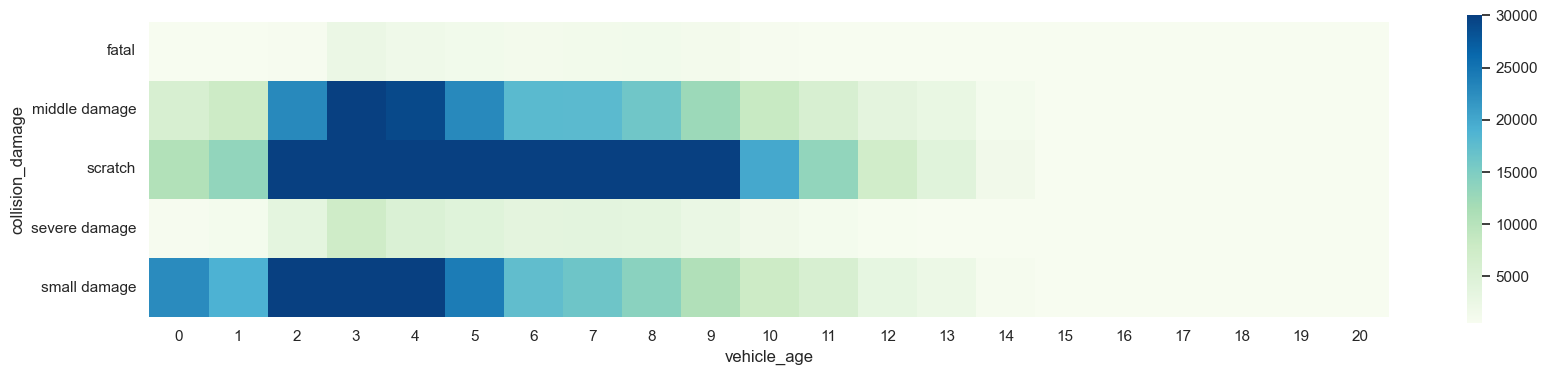

In [40]:
c11['vehicle_age'] = c11['vehicle_age'].astype('object') 
c11 = c11.pivot("collision_damage","vehicle_age",  "age_damage")
c11.fillna(0, inplace=True)
fig, ax = plt.subplots(figsize=(20, 8) ) 

ax = sns.heatmap(c11, vmin=500, vmax=30000, cbar_kws={"shrink": 0.5},
                 cmap = "GnBu",square=True)


После аварии более других не подлежат восстановлению автомобили возраста 3 года, серьезный ремонт чаще требуется этим же машинам, а также возраста 4-12 лет, среднему ремонту подлежат машины 3-4 года, ремонту отдельных элементов более других подвержены автомобили 2-4 года, царапины остаются чаще всего на машинах возраста 2-9 лет.  


<b> Вывод:</b> Изучением данных, характеризующих техническое состояние автомобилей, побывавших в аварии установлено следующее.
    
Всего в данных имеются сведения о 1021234 автомобилях каршеринговой компании, побывавших в аварии.
    
Количество автомобилей с автоматической и ручной коробкой передач примерно одинаково (около 500 тыс.). 
    
Возраст автомобилей, чаще других попадавших в ДТП составляет 2-5 лет. После этого количество автомобилей снижается по мере увеличения возраста. Возможно это связано со снижением общего количества машин по мере их устаревания.В данных имеется аномальное значение - 17 автомобилей, возраст которых составляет 161 год. 
    
После аварии более других не подлежат восстановлению автомобили возраста 3 года, серьезный ремонт чаще требуется этим же машинам, а также возраста 4-10 лет, среднему ремонту подлежат машины 3-4 года, ремонту отдельных элементов более других подвержены автомобили 2-4 года, царапины остаются чаще всего на машинах возраста 2-9 лет. 
</div>  

## Создание модели для оценки водительского риска

### Формирование датасета и предварительная обработка данных

Для формирования датасета, на основании которого построим модель предсказаний, из таблицы "Parties" с условием party_type = 'car' (тип участника - машина) выделим признаки:
-  "at_fault" (виновность участника) - целевой признак,
-  "party_sobriety" (трезвость участника) -степень рискованности водителя напрямую зависит от его физического состояния,

из таблицы "collisions" с условием collision_date = '2012' (год происшествия 2012) и collision_damage != 'scratch' (повреждение авто - не царапина) выделим признаки:
-  "county_city_location" (номер географических районов, где произошло ДТП) - общеизвестно, что степень аварийности в регионах различается,
-  "collision_time" (время происшествия) - риск ДТП повышается в наиболее "загруженное" для движения время суток,
-  "weather_1" (погода) - является внешним фактором, влияющим на видимость, состояние дороги,от которых напрямую зависит аварийность не только автомобилей, но илюбых других движущихся средств (поездов, самолетов..),
-  "intersection" (является ли место происшествия перекрёстком) - перекресток - место маневра, т.е. повышенного риска для ДТП,
-  "road_surface" (состояние дороги), "lighting" (освещение), "road_condition_1" (дорожное состояние) - также внешние факторы, важные для безопасного движения,
-  "distance" (расстояние от главной дороги) - вполне может повлиять на степень риска, ведь общеизвестно, что чем незначительней дорога, тем скорее водитель пренебрежет ПДД,
-  "control_device" (устройство управления) - от технического состояния автомобиля напрямую зависит насколько безопасной будет езда,

из таблицы "Vehicles" с условием vehicle_age < 16 (сразу удалим аномалии и выбросы из данных о возрасте автомобиля) выделим признаки:
-  "vehicle_type" (vehicle_type) и "vehicle_age" (возраст автомобиля) - также как и "control_device" характеризуют техническое состояние автомобиля.

Объединяющим ключом станет "case_id", для контроля соблюдения условия отбора данных за 2012 год также выведем и этот столбец.

In [41]:
query = '''
WITH
n AS (SELECT case_id,
       at_fault,
       party_sobriety
FROM Parties
where party_type = 'car'),

nn AS (SELECT case_id,
       county_city_location,
       EXTRACT(YEAR FROM collision_date) as year,
       EXTRACT(HOUR FROM collision_time) as collision_time,
       weather_1,
       intersection,
       road_surface,
       lighting,
       distance,
       road_condition_1,
       control_device
FROM collisions
WHERE EXTRACT(YEAR FROM collision_date) = '2012'
AND collision_damage != 'scratch'),

nnn AS (SELECT case_id,
       vehicle_type,
       vehicle_age
FROM Vehicles
where vehicle_age < 16)

SELECT * 
FROM n 
INNER JOIN nn ON n.case_id = nn.case_id     
INNER JOIN nnn ON nnn.case_id = nn.case_id 
'''
data = pd.read_sql_query(query, con=engine) 

Изучаем полученный датасет

In [42]:
display(data.head())
data.info()
data.isna().sum()

,case_id,at_fault,party_sobriety,case_id,county_city_location,year,collision_time,weather_1,intersection,road_surface,lighting,distance,road_condition_1,control_device,case_id,vehicle_type,vehicle_age
0,5125160,0,had not been drinking,5125160,3712,2012.0,7.0,cloudy,1.0,dry,daylight,0.0,other,none,5125160,sedan,2
1,5125160,1,had not been drinking,5125160,3712,2012.0,7.0,cloudy,1.0,dry,daylight,0.0,other,none,5125160,sedan,2
2,5173738,0,had not been drinking,5173738,3404,2012.0,12.0,clear,1.0,dry,daylight,0.0,normal,none,5173738,sedan,5
3,5173738,1,had not been drinking,5173738,3404,2012.0,12.0,clear,1.0,dry,daylight,0.0,normal,none,5173738,sedan,5
4,5269486,0,had not been drinking,5269486,3400,2012.0,16.0,clear,1.0,dry,daylight,0.0,normal,functioning,5269486,sedan,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115015 entries, 0 to 115014
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   case_id               115015 non-null  object 
 1   at_fault              115015 non-null  int64  
 2   party_sobriety        113352 non-null  object 
 3   case_id               115015 non-null  object 
 4   county_city_location  115015 non-null  object 
 5   year                  115015 non-null  float64
 6   collision_time        114895 non-null  float64
 7   weather_1             114633 non-null  object 
 8   intersection          114663 non-null  float64
 9   road_surface          114292 non-null  object 
 10  lighting              114690 non-null  object 
 11  distance              115015 non-null  float64
 12  road_condition_1      114470 non-null  object 
 13  control_device        114579 non-null  object 
 14  case_id               115015 non-null  object 
 15  

case_id                    0
at_fault                   0
party_sobriety          1663
case_id                    0
county_city_location       0
year                       0
collision_time           120
weather_1                382
intersection             352
road_surface             723
lighting                 325
distance                   0
road_condition_1         545
control_device           436
case_id                    0
vehicle_type               0
vehicle_age                0
dtype: int64

Сформированный датасет насчитывает 115015 объектов, 1 столбец с целевым признаком и 16 столбцов с признаками. В 8 столбцах содержатся пропуски, которые мы удалим. Также удалим "case_id" (объединяющий ключ) и "year", т.к. он был выбран для контроля правильности отбора данных по 2012 году.

In [43]:
data = data.drop(columns=['case_id', 'year'],axis=1 )
data = data.dropna()
data.info()
data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111130 entries, 0 to 115014
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   at_fault              111130 non-null  int64  
 1   party_sobriety        111130 non-null  object 
 2   county_city_location  111130 non-null  object 
 3   collision_time        111130 non-null  float64
 4   weather_1             111130 non-null  object 
 5   intersection          111130 non-null  float64
 6   road_surface          111130 non-null  object 
 7   lighting              111130 non-null  object 
 8   distance              111130 non-null  float64
 9   road_condition_1      111130 non-null  object 
 10  control_device        111130 non-null  object 
 11  vehicle_type          111130 non-null  object 
 12  vehicle_age           111130 non-null  int64  
dtypes: float64(3), int64(2), object(8)
memory usage: 11.9+ MB


at_fault                0
party_sobriety          0
county_city_location    0
collision_time          0
weather_1               0
intersection            0
road_surface            0
lighting                0
distance                0
road_condition_1        0
control_device          0
vehicle_type            0
vehicle_age             0
dtype: int64

После удаления объектов с пропусками датасет составляет 111130 объектов. Исследуем целевой признак и признаки. 

<b> Целевой признак </b>

In [44]:
print('соотношение классов на исходном датасете:', round(((data['at_fault'][data['at_fault'] == 0]).count(
                                                              )/(data['at_fault'][data['at_fault'] == 1]).count()),3))

соотношение классов на исходном датасете: 1.141


0    59214
1    51916
Name: at_fault, dtype: int64

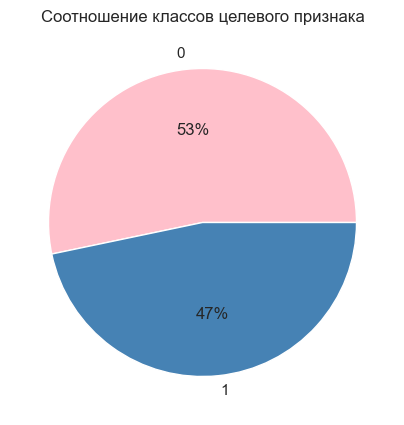

In [45]:
display(data['at_fault'].value_counts())

a = data.groupby('at_fault').size()
a.plot(kind='pie', subplots=True, colors = ['pink', 'steelblue'],autopct='%1.0f%%', figsize=(5, 5)) 
plt.title("Соотношение классов целевого признака")
plt.ylabel("")
plt.show()

В наборе данных целевого признака в сформированном нами датасете отмечается незначительный, но все-таки дисбаланс классов а сторону увеличения числа объектов отрицательного класса. 

<b> Трезвость участника </b>

In [46]:
data['party_sobriety'].value_counts()

had not been drinking                     97295
had been drinking, under influence         6199
impairment unknown                         5667
had been drinking, not under influence      933
not applicable                              523
had been drinking, impairment unknown       513
Name: party_sobriety, dtype: int64

Данные признака 'party_sobriety' содержат категориальные значеня,которые можно категоризировать: объединим значения 'had been drinking, under influence','had been drinking, not under influence', 'had been drinking, impairment unknown', поскольку алкоголь в любом количестве за рулем - это все равно употребление алкоголя; объединим 'impairment unknown'и'not applicable', т.к. в обоих случаях состояние неизвестно, упростим название 'had not been drinking'. Напишем для этого функцию замены.

In [47]:
def replace_meaning(first,correct):
    data['party_sobriety'] = data['party_sobriety'].replace(first,correct)
replace_meaning(['impairment unknown','not applicable'], 'unknown')
replace_meaning(['had been drinking, under influence','had been drinking, not under influence',
                                                        'had been drinking, impairment unknown'],'drinking')
replace_meaning('had not been drinking','not drinking')
data['party_sobriety'].value_counts()

not drinking    97295
drinking         7645
unknown          6190
Name: party_sobriety, dtype: int64

<b> Номер географических районов ДТП </b>

In [48]:
data['county_city_location'].value_counts()

1942    14822
1900     4410
3711     2737
3400     2234
4313     1855
        ...  
2101        1
1504        1
2111        1
0501        1
5008        1
Name: county_city_location, Length: 494, dtype: int64

'county_city_location' - категориальный признак в цифровом виде, оставим его без изменения

<b> Время происшествия </b>

Для исследования времени суток совершения ДТП визуализиоуем этот показатель.

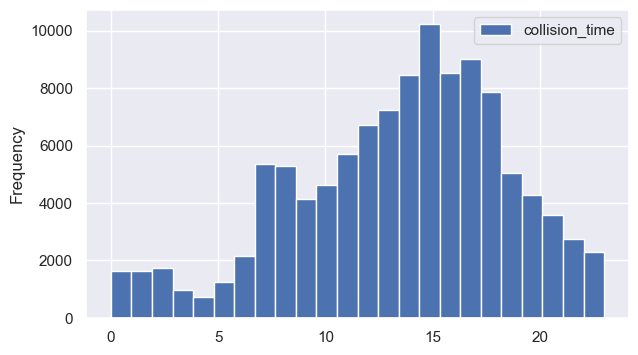

In [49]:
data['collision_time'].value_counts()
sns.set_style("darkgrid")
data['collision_time'].plot(kind = 'hist', bins = 24, grid = True, legend = 'collision_time', figsize = (7,4))
plt.show()

Наиболее аварийное время - с 13 до 18 часов. Пик ДТП приходится на 15 часов, самыми безопасными являются 3-4 часа.

<b> Погода </b>

In [50]:
data['weather_1'].value_counts()

clear      90388
cloudy     16072
raining     3966
fog          363
snowing      260
other         58
wind          23
Name: weather_1, dtype: int64

Данные столбца 'weather_1' все реалистичны, оставим их без изменения.

<b> Является ли место происшествия перекрёстком </b>

In [51]:
data['intersection'].value_counts()

0.0    85508
1.0    25622
Name: intersection, dtype: int64

Категориальный принак 'intersection' переведен в числовой, оставим без изменения.

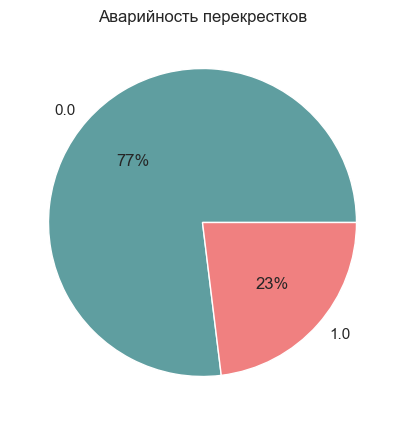

In [52]:
intersection = data.groupby('intersection').size()
intersection.plot(kind='pie', subplots=True, colors = ['cadetblue','lightcoral'], autopct='%1.0f%%', figsize=(5, 5)) 
plt.title("Аварийность перекрестков")
plt.ylabel("")
plt.show()

Аварии на перекрестках случаются в три раза реже чем вне перекрестков

<b> Состояние дороги </b>

In [53]:
data['road_surface'].value_counts()

dry         100966
wet           9564
snowy          536
slippery        64
Name: road_surface, dtype: int64

Данные столбца 'road_surface' также реалистичны, без дополнительной визуализации видно, что подавляющее большинство аварий случается на сухой дороге.

<b> Освещение </b>

In [54]:
data['lighting'].value_counts()

daylight                                   78182
dark with street lights                    20493
dark with no street lights                  8697
dusk or dawn                                3490
dark with street lights not functioning      268
Name: lighting, dtype: int64

В столбце 'lighting' признаки 'dark with no street lights' и 'dark with street lights not functioning' можно объединить в одно значение, так как неработающие уличные фонари равносильны отсутствию уличного освещения.

In [55]:
data['lighting'] = data['lighting'].replace(['dark with no street lights','dark with street lights not functioning'
                                            ], 'not street lights') 
data['lighting'].value_counts()

daylight                   78182
dark with street lights    20493
not street lights           8965
dusk or dawn                3490
Name: lighting, dtype: int64

<b> Расстояние от главной дороги </b>

0.0       26911
100.0      3774
200.0      3280
300.0      2822
500.0      2785
528.0      2755
1056.0     2714
50.0       2554
1584.0     2170
2640.0     1941
Name: distance, dtype: int64

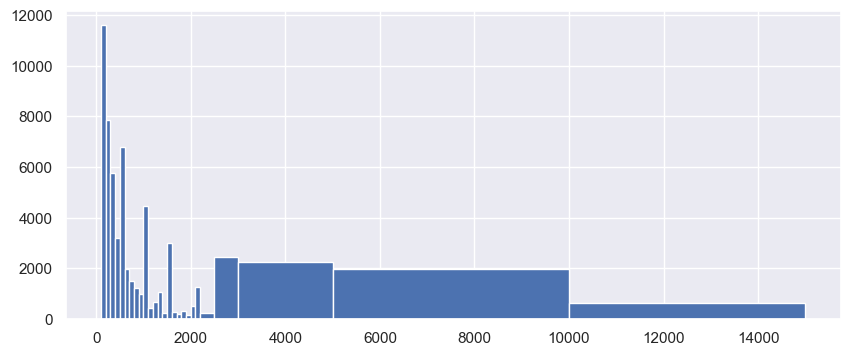

In [56]:
ax = data['distance'].hist(bins = [100,200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 
                              1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2500, 3000, 
                              5000, 10000, 15000 ], figsize=(10, 4))
data['distance'].value_counts().head(10)

In [57]:
data['distance'].describe()

count    1.111300e+05
mean     7.501183e+02
std      7.108948e+03
min      0.000000e+00
25%      5.000000e+00
50%      1.250000e+02
75%      5.280000e+02
max      1.584000e+06
Name: distance, dtype: float64

Расстояние от главной дороги - количественный признак. Данные за пределами 10000 можно считать выбросами, но избавляться от них не будем.

<b> Дорожное состояние </b>

In [58]:
data['road_condition_1'].value_counts()

normal            107491
construction        2200
obstruction          434
other                395
holes                265
loose material       182
reduced width        109
flooded               54
Name: road_condition_1, dtype: int64

Данные о состоянии проезжей части оставим без изменения. В подавляющем большинстве случаев это нормальная дорога.

<b> Устройство управления </b>

In [59]:
data['control_device'].value_counts()

none               72963
functioning        37891
not functioning      222
obscured              54
Name: control_device, dtype: int64

В столбце 'control_device' значения 'not functioning' и 'obscured' в минимальном количестве и равносильны отсутствию устройства управления, по-этому объединим их со значением 'none'.

In [60]:
data['control_device'] = data['control_device'].replace(['not functioning','obscured'], 'none') 
data['control_device'].value_counts()

none           73239
functioning    37891
Name: control_device, dtype: int64

<b> Тип кузова </b>

In [61]:
data['vehicle_type'].value_counts()

sedan        71393
coupe        34293
hatchback     3085
minivan       2313
other           46
Name: vehicle_type, dtype: int64

Данные о типе кузова оставим без изменения

<b>Возраст автомобиля   </b>

In [62]:
data['vehicle_age'].value_counts()

3     20898
4     14119
2     12428
5     11383
6      8226
7      8081
8      7402
0      6525
9      5890
1      5499
10     4149
11     2911
12     1819
13     1138
14      583
15       79
Name: vehicle_age, dtype: int64

Из данных 'vehicle_age' мы убрали аномальные и единичные значения на стадии формирования общего датасета, оставив автомобили не старше 15 лет

### Подготовка признаков

Разделяем данные на выборки для обучения и тестирования в соотношении 3:1. Чтоб избежать утечки данных признаков дальнейшую обработку данных будем производить отдельно по каждой выборке.

In [63]:
train_features, test_features, train_target, test_target = train_test_split(
    data.drop('at_fault', axis=1), data.at_fault, test_size=0.25, random_state=12345, stratify=data['at_fault'],shuffle=True)

print('Размеры выборок:')
print('train_features',train_features.shape)
print('test_features', test_features.shape)
print('train_target', train_target.shape)
print('test_target', test_target.shape)

Размеры выборок:
train_features (83347, 12)
test_features (27783, 12)
train_target (83347,)
test_target (27783,)


Проверяем равномерность распределения в учебной и тестовых выборках значений категориальных признаков, представленных текстом. Для этого создадим небольшую функцию.

In [64]:
def count_attribute(attribute):
    print(len(train_features[attribute].sort_values().unique()))
    print(len(test_features[attribute].sort_values().unique()))
    print('')
    
count_attribute('party_sobriety')
count_attribute('weather_1')    
count_attribute('road_surface')
count_attribute('lighting')
count_attribute('road_condition_1')
count_attribute('control_device')
count_attribute('vehicle_type')

3
3

7
7

4
4

4
4

8
8

2
2

5
5



Проверяем соотношение классов на учебной и тестовой выборках

In [65]:
print('соотношение классов на учебной выборке:', round((train_target[train_target == 0
                                                             ].count()/train_target[train_target == 1].count()),3))

print('соотношение классов на тестовой выборке:', round((test_target[test_target == 0].count()/
                                                         test_target[test_target == 1].count()),3))

соотношение классов на учебной выборке: 1.141
соотношение классов на тестовой выборке: 1.141


Кодируем признаки техникой OHE

In [66]:
categorical = ['party_sobriety',  'weather_1',  'road_surface', 'lighting', 
               'road_condition_1','control_device', 'vehicle_type']
numerics = ['county_city_location','collision_time', 'intersection','distance', 'vehicle_age']#  


onehot_encoder = OneHotEncoder(handle_unknown='ignore',sparse=False, drop='first')

result_train = onehot_encoder.fit_transform(train_features[categorical])
result_train = pd.DataFrame(result_train, columns=onehot_encoder.get_feature_names_out(categorical), index=train_features.index)

features_ohe_train = result_train.join(train_features[numerics])
display(features_ohe_train.head(3))
features_ohe_train.info()

,party_sobriety_not drinking,party_sobriety_unknown,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,road_surface_slippery,road_surface_snowy,...,control_device_none,vehicle_type_hatchback,vehicle_type_minivan,vehicle_type_other,vehicle_type_sedan,county_city_location,collision_time,intersection,distance,vehicle_age
44975,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1914,2.0,0.0,200.0,8
1983,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3801,8.0,1.0,0.0,7
93774,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,4502,10.0,1.0,0.0,6


<class 'pandas.core.frame.DataFrame'>
Int64Index: 83347 entries, 44975 to 104870
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   party_sobriety_not drinking      83347 non-null  float64
 1   party_sobriety_unknown           83347 non-null  float64
 2   weather_1_cloudy                 83347 non-null  float64
 3   weather_1_fog                    83347 non-null  float64
 4   weather_1_other                  83347 non-null  float64
 5   weather_1_raining                83347 non-null  float64
 6   weather_1_snowing                83347 non-null  float64
 7   weather_1_wind                   83347 non-null  float64
 8   road_surface_slippery            83347 non-null  float64
 9   road_surface_snowy               83347 non-null  float64
 10  road_surface_wet                 83347 non-null  float64
 11  lighting_daylight                83347 non-null  float64
 12  lighting_dusk

In [67]:
result_test = onehot_encoder.transform(test_features[categorical])
result_test = pd.DataFrame(result_test, columns=onehot_encoder.get_feature_names_out(categorical), index=test_features.index)

features_ohe_test = result_test.join(test_features[numerics])
display(features_ohe_test.head(3))
features_ohe_test.info()

,party_sobriety_not drinking,party_sobriety_unknown,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,road_surface_slippery,road_surface_snowy,...,control_device_none,vehicle_type_hatchback,vehicle_type_minivan,vehicle_type_other,vehicle_type_sedan,county_city_location,collision_time,intersection,distance,vehicle_age
70848,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1942,14.0,0.0,200.0,11
94338,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1005,15.0,0.0,340.0,9
79482,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,5604,12.0,0.0,300.0,7


<class 'pandas.core.frame.DataFrame'>
Int64Index: 27783 entries, 70848 to 34144
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   party_sobriety_not drinking      27783 non-null  float64
 1   party_sobriety_unknown           27783 non-null  float64
 2   weather_1_cloudy                 27783 non-null  float64
 3   weather_1_fog                    27783 non-null  float64
 4   weather_1_other                  27783 non-null  float64
 5   weather_1_raining                27783 non-null  float64
 6   weather_1_snowing                27783 non-null  float64
 7   weather_1_wind                   27783 non-null  float64
 8   road_surface_slippery            27783 non-null  float64
 9   road_surface_snowy               27783 non-null  float64
 10  road_surface_wet                 27783 non-null  float64
 11  lighting_daylight                27783 non-null  float64
 12  lighting_dusk 

Стандартизируем признаки, представленные числовыми данными

In [68]:
scaler = StandardScaler()

scaler.fit(features_ohe_train[numerics]) 
features_ohe_train[numerics] = scaler.transform(features_ohe_train[numerics])
display(features_ohe_train.head(3))

features_ohe_test[numerics] = scaler.transform(features_ohe_test[numerics])
display(features_ohe_test.head(3))

,party_sobriety_not drinking,party_sobriety_unknown,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,road_surface_slippery,road_surface_snowy,...,control_device_none,vehicle_type_hatchback,vehicle_type_minivan,vehicle_type_other,vehicle_type_sedan,county_city_location,collision_time,intersection,distance,vehicle_age
44975,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,-0.716914,-2.202145,-0.548686,-0.069074,0.993474
1983,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.759439,-1.054002,1.822535,-0.093779,0.673341
93774,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.307888,-0.671287,1.822535,-0.093779,0.353208


,party_sobriety_not drinking,party_sobriety_unknown,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,road_surface_slippery,road_surface_snowy,...,control_device_none,vehicle_type_hatchback,vehicle_type_minivan,vehicle_type_other,vehicle_type_sedan,county_city_location,collision_time,intersection,distance,vehicle_age
70848,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,-0.695008,0.094141,-0.548686,-0.069074,1.953873
94338,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.428099,0.285499,-0.548686,-0.051780,1.313607
79482,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,2.170072,-0.288573,-0.548686,-0.056721,0.673341



<b> Вывод:</b>

Сформированный датасет насчитывает 115015 объектов, 1 столбец с целевым признаком и 16 столбцов с признаками. Три столбца "case_id" и признак "year" при построении модели машинного обучения мы не станем учитывать, поскольку первый из них является объединяющим ключем к трем таблицам, а признак с номером года выделен для контроля правильности условия формирования датасета.
    
Целевой признак классицирован по бинарному типу, в нем отмечается незначительный дисбаланс классов. Также имеется 3 количественных признака, два категориальных "county_city_location"  и "intersection" переведены в числовые данные, остальные признаки категориальные.
    
Предварительная обработка данных включала следующее:
-  удалены пропуски из 8 столбцов, после чего датасет стал насчитывать 111130 объектов (удаленная часть составила не более 5% исходных данных);
-  из данных 'vehicle_age' убраны аномальные и единичные значения на стадии формирования общего датасета;
-  данные признака 'party_sobriety' категоризированы путем объединения значений 'had been drinking, under influence','had been drinking, not under influence', 'had been drinking, impairment unknown' в один, а также объединения значений 'impairment unknown'и'not applicable';
-  в столбце 'lighting' значения 'dark with no street lights' и 'dark with street lights not functioning' объединены в одно;
-  в столбце 'control_device' значения 'not functioning' и 'obscured' объединены со значением 'none'.  

Данные о номере региона ДТП, времени происшествия, аварийности перекрестков, состоянии дороги, расстоянии от главной дороги, типе кузова, состоянии проезжей части, оставлены без изменения.
    
Подготовка признаков для построения модели машинного обучения состояла в следующем:
-  данные разделены на выборки для обучения и тестирования в соотношении 3:1, дальнейшая их обработка производилась раздельно по выборкам;
    
-  категориальные признаки, представленные текстом, кодированы техникой OHE;
    
-  количественные признаки и категориальные, переведенные в числовые данные, стандартизированы.
    
В целевом признаке учебного и тестового набора данных отмечается дисбаланс в сторону увеличения числа объектов отрицательного класс в соотношении 1:1.41. Устранение дисбаланса классов произведем при построении моделей машинного обучения, применив различные способы борьбы с дисбалансом. 

### Построение моделей машинного обучения.

Построим модели:
-  "Дерево решений", применив  в качестве борьбы с дисбалансом классов целевого признака аргумент class_weight='balanced';
-  "Дерево решений", применив функцию Downsampling по уменьшению числа объектов отрицательного класса;
-  "Случайный лес", применив функцию Downsampling по уменьшению числа объектов отрицательного класса;
-  модель градиентного бустинга средствами библиотеки lightgbm, применив функцию Downsampling по уменьшению числа объектов отрицательного класса;
-  модель градиентного бустинга средствами библиотеки catboost с категориальными признаками в первоначальном виде.

Перед построением каждой модели предварительно подберем наилучшие гиперпараметры. 

При выборе метрики качества будем исходить из следующего. Перед нами стоит задаа бинарной классификации. При этом мы имеем дело с небольшим дисбалансом классов при котороим метрика Accuracy неэффективна. Вместе с тем мы не можем отдать предпочтение какому-либо одному классу. Задача, поставленная в том виде, как она сформулирована заказчиком, сводится к тому, чтоб предсказать "рискованность" клиента и дать рекомендации по маршруту. Но рекомендации по маршруту нужны каждому водителю независимо от риска. Для этого более значимым представляется установить важность факторов ДТП. То есть для нас имеет значение правильное предсказание обоих классов. По этой причине мы не станем ориентироваться на F-меру, более ориентированную на положительный класс и метрикой качества выберем AUC-ROC. Для ее визуализации сохраним метрику по каждой модели в отдельной переменной 

 Перебор гиперпараметров осуществим посредством модуля GridSearchCVВ, который работает по принципу кросс-валидации. В указанной связи мы не будем делать дополнительной кросс-валидации, а после подбора гиперпараметров по каждой модели  выведем данные этих параметров и значение метрики, которую передавали в scoring. Построим таблицу и график полученных метрик, выберем по ним лучшую модель, которую протестируем.

#### Дерево решений tree_model_balanced

In [69]:
STATE = RandomState(12345)

In [70]:
# Подбираем гиперпараметры для модели с аргументом class_weight='balanced'

parametrs = {'min_samples_leaf': range (1,11,2),
             'max_depth': range (1,10)} 
tree_model_balanced = GridSearchCV(DecisionTreeClassifier(random_state=STATE, class_weight = 'balanced'), 
                          parametrs, scoring='roc_auc', cv=5) # ,
tree_model_balanced.fit(features_ohe_train,train_target)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=RandomState(MT19937) at 0x122DDDA5D40),
             param_grid={'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 11, 2)},
             scoring='roc_auc')

In [71]:
# Выводим лучшие гиперпараметры и заданную метрику 

print("Лучшие гиперпараметры для модели 'Дерево решений':", tree_model_balanced.best_params_)
print("AUC ROC:",round((tree_model_balanced.best_score_),3))

Лучшие гиперпараметры для модели 'Дерево решений': {'max_depth': 9, 'min_samples_leaf': 7}
AUC ROC: 0.614


Ддля построения моделей "Дерево решений", "Случайный лес" и градиентного бустинга библиотекой lightgbm с выравниванием классов путем уменьшения числа объектов отрицательного класса создадим контейнер pipeline, в котором применим технику кодирования OrdinalEncoder и передадим для обучения признаки, полученные путем применения к исходным признакам функции downsampling, для вписывания которой  в pipeline мы импортировали модуль imbalanced-learn

 Создаем трансформер, категориальные признаки кодируем OrdinalEncoder, числовые стандартизируем StandardScaler. Зададим параметры handle_unknown='use_encoded_value', unknown_value=-1, благодаря которым OrdinalEncoder будет кодировать неизвестные значения и использовать для этого "-1":

In [72]:
transform = make_column_transformer(
    (
        OrdinalEncoder(
            dtype='int16',
            handle_unknown= 'use_encoded_value',
            unknown_value=-1
        ), make_column_selector(dtype_include=['category', 'object'])
    ),
    (
        StandardScaler(
        ), make_column_selector(dtype_include='number')),
    remainder='passthrough'
)

#### Дерево решений при уменьшении числа объектов отрицательного класса

In [73]:
# Создаем pipeline для Дерева решений
undersample_pipe_dt = make_imb_pipeline(transform,
                                        RandomUnderSampler(random_state=STATE),
                                         DecisionTreeClassifier(random_state=STATE))
# Задаем параметры
param_grid = {
    'decisiontreeclassifier__min_samples_leaf': np.arange(1,9,2),
    'decisiontreeclassifier__max_depth':np.arange(1, 10, 2)
}

# Передаем в оценщик
dt = GridSearchCV(
    undersample_pipe_dt,
    param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

In [74]:
# Обучаем модель на тренировочных данных

dt.fit(train_features,train_target)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(dtype='int16',
                                                                                        handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000122E40A4820>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.comp...
                                       ('randomundersampler',
                                        RandomUnderSampler(random_state=RandomState(MT19937) at 0x122DDDA5D40)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=RandomState(MT19937) at 0x122DDDA5D40))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': array([1, 3, 5, 7, 9]),
                         'decisiontreeclassifier__min_samples_leaf': array([1, 3, 5, 7])},
             scoring='roc_auc', verbose=1)

In [75]:
# Выводим лучшие гиперпараметры и заданную метрику 

print("Лучшие гиперпараметры для модели 'Дерево решений' при уменьшении числа объектов отрицательного класса :",
      dt.best_params_)
print('')
print("AUC ROC:", round((dt.best_score_),3))

Лучшие гиперпараметры для модели 'Дерево решений' при уменьшении числа объектов отрицательного класса : {'decisiontreeclassifier__max_depth': 9, 'decisiontreeclassifier__min_samples_leaf': 7}

AUC ROC: 0.614


#### Модель "Случайный лес" при уменьшении числа объектов отрицательного класса

In [76]:
# Создаем pipeline для Случайного леса
undersample_pipe_rf = make_imb_pipeline(transform,
                                        RandomUnderSampler(random_state=STATE),
                                        RandomForestClassifier(random_state=STATE,
                                        n_jobs=-1,
                                        verbose=0)
                                       )
    
# Задаем параметры
param_grid = {
    'randomforestclassifier__min_samples_leaf': np.arange(1,5,2),
    'randomforestclassifier__n_estimators':np.arange(100, 151, 50),
    'randomforestclassifier__max_features': ['sqrt', 'log2', None],
    'randomforestclassifier__max_depth':np.arange(1, 10, 2)
}

# Передаем в оценщик
rf = GridSearchCV(
    undersample_pipe_rf,
    param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

In [77]:
# Обучаем модель на тренировочных данных

rf.fit(train_features,train_target)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(dtype='int16',
                                                                                        handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000122E40A4820>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.comp...
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=RandomState(MT19937) at 0x122DDDA5D40))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': array([1, 3, 5, 7, 9]),
                         'randomforestclassifier__max_features': ['sqrt',
                                                                  'log2',
                                                                  None],
                         'randomforestclassifier__min_samples_leaf': array([1, 3]),
                         'randomforestclassifier__n_estimators': array([100, 150])},
             scoring='roc_auc', verbose=1)

In [78]:
# Выводим лучшие гиперпараметры и заданную метрику 

print("Лучшие гиперпараметры для модели 'Случайный лес при уменьшении числа объектов отрицательного класса':",
      rf.best_params_)
print('')
print("AUC ROC:", round((rf.best_score_),3))

Лучшие гиперпараметры для модели 'Случайный лес при уменьшении числа объектов отрицательного класса': {'randomforestclassifier__max_depth': 7, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__n_estimators': 150}

AUC ROC: 0.626


#### Модель градиентного бустинга lgb_model_best средствами библиотеки lightgbm

In [79]:
# Создаем pipeline для модели градиентного бустинга lightgbm

undersample_pipe_lgbm = make_pipeline(
    transform,
    RandomUnderSampler(random_state=STATE),
    lgb.LGBMClassifier(
        objective='binary',
        metric='roc_auc',
        n_jobs=-1,
        verbosity=-1,
        random_state= STATE
    )
)
# Задаем параметры
param_grid = {
    'lgbmclassifier__max_depth':[5, 10, 15, 20],
    'lgbmclassifier__min_split_gain':[0.0,0.1,0.2,0.3],
    'lgbmclassifier__learning_rate':[0.01, 0.1, 1],
    'lgbmclassifier__n_estimators': [20, 40]
}
# Передаем в оценщик
lgbm = GridSearchCV(
    undersample_pipe_lgbm,
    param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

In [80]:
# Обучаем модель на тренировочных данных

lgbm.fit(train_features,train_target)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(dtype='int16',
                                                                                        handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000122E40A4820>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.comp...
                                       ('lgbmclassifier',
                                        LGBMClassifier(metric='roc_auc',
                                                       objective='binary',
                                                       random_state=RandomState(MT19937) at 0x122DDDA5D40,
                                                       verbosity=-1))]),
             n_jobs=-1,
             param_grid={'lgbmclassifier__learning_rate': [0.01, 0.1, 1],
                         'lgbmclassifier__max_depth': [5, 10, 15, 20],
                         'lgbmclassifier__min_split_gain': [0.0, 0.1, 0.2, 0.3],
                         'lgbmclassifier__n_estimators': [20, 40]},
             scoring='roc_auc', verbose=1)

In [81]:
# Выводим лучшие гиперпараметры и заданную метрику 

print("Лучшие гиперпараметры для модели LGBMClassifier:", lgbm.best_params_)
print('')
print("AUC ROC:", round((lgbm.best_score_),4))

Лучшие гиперпараметры для модели LGBMClassifier: {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 20, 'lgbmclassifier__min_split_gain': 0.0, 'lgbmclassifier__n_estimators': 40}

AUC ROC: 0.6304


#### Модель градиентного бустинга средствами библиотеки catboost с первоначальными признаками

В модели градиентного бустинга CatBoost для обучения передаются некодированные и нестандартизированные признаки учебной выборки без применения методов выравнивания классов.

In [82]:
# Формируем данные для передачи некодированных и нестандартизированных признаков учебной выборки модели CatBoost

cat_features = ['party_sobriety', 'weather_1',  'road_surface', 
                'lighting', 'road_condition_1', 'control_device', 'vehicle_type']   

train_dataset = cb.Pool(train_features,train_target, cat_features=cat_features)                                                      
test_dataset = cb.Pool(test_features,test_target, cat_features=cat_features)

In [83]:
# Задаем параметры модели, которые передаем в модель CatBoost

params = {'verbose':100,
          'eval_metric':'AUC',
          'loss_function': 'Logloss',
          'random_seed':12345}

model = CatBoostClassifier(**params)

# Создаем сетку для перебора гиперпараметров

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [3, 5, 8],
        'iterations': [100, 150, 200]
    
    }

# Передаем в оценщик
result = model.grid_search(grid, train_dataset, verbose=False)


0:	test: 0.6019452	best: 0.6019452 (0)	total: 220ms	remaining: 21.8s
99:	test: 0.6324764	best: 0.6325760 (95)	total: 4.35s	remaining: 0us

bestTest = 0.6325759817
bestIteration = 95

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	test: 0.6019452	best: 0.6019452 (0)	total: 45.1ms	remaining: 4.47s
99:	test: 0.6375231	best: 0.6377077 (76)	total: 4.32s	remaining: 0us

bestTest = 0.6377076822
bestIteration = 76

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	test: 0.6019452	best: 0.6019452 (0)	total: 48.4ms	remaining: 4.79s
99:	test: 0.6275105	best: 0.6275105 (99)	total: 4.44s	remaining: 0us

bestTest = 0.6275105262
bestIteration = 99

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	test: 0.6019452	best: 0.6019452 (0)	total: 4

99:	test: 0.6389147	best: 0.6390168 (87)	total: 5.48s	remaining: 0us

bestTest = 0.6390167937
bestIteration = 87

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	test: 0.6037814	best: 0.6037814 (0)	total: 62.6ms	remaining: 9.33s
100:	test: 0.6363652	best: 0.6363652 (100)	total: 5.77s	remaining: 2.8s
149:	test: 0.6382063	best: 0.6382063 (149)	total: 8.6s	remaining: 0us

bestTest = 0.6382063411
bestIteration = 149

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	test: 0.6037814	best: 0.6037814 (0)	total: 64.5ms	remaining: 9.62s
100:	test: 0.6391731	best: 0.6395180 (84)	total: 5.71s	remaining: 2.77s
149:	test: 0.6397030	best: 0.6397030 (149)	total: 8.65s	remaining: 0us

bestTest = 0.6397029612
bestIteration = 149

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_t

100:	test: 0.6363440	best: 0.6363867 (98)	total: 10s	remaining: 4.88s
149:	test: 0.6363500	best: 0.6365336 (109)	total: 15.5s	remaining: 0us

bestTest = 0.6365335618
bestIteration = 109

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	test: 0.6053174	best: 0.6053174 (0)	total: 76.4ms	remaining: 11.4s
100:	test: 0.6336968	best: 0.6368452 (31)	total: 10.4s	remaining: 5.04s
149:	test: 0.6271256	best: 0.6368452 (31)	total: 16.3s	remaining: 0us

bestTest = 0.6368452326
bestIteration = 31

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	test: 0.6026706	best: 0.6026706 (0)	total: 54.5ms	remaining: 10.9s
100:	test: 0.6361636	best: 0.6362461 (98)	total: 12.2s	remaining: 12s
199:	test: 0.6361264	best: 0.6365616 (159)	total: 25.8s	remaining: 0us

bestTest = 0.6365616168
bestIteration = 159

Metric AUC is not calculated on

In [84]:
# Выводим лучшие гиперпараметры и заданную метрику 

print("Лучшие гиперпараметры для модели CatBoost с первоначальными признаками:",  result['params'])
print('')
print("AUC ROC:",round(pd.DataFrame(result['cv_results'])['test-AUC-mean'].max(),3))

Лучшие гиперпараметры для модели CatBoost с первоначальными признаками: {'depth': 6, 'l2_leaf_reg': 8, 'iterations': 200, 'learning_rate': 0.1}

AUC ROC: 0.634



<b> Вывод:</b> Мы построили несколько моделей машинного обучения: два "Дерева решений" (с применением в качестве борьбы с дисбалансом классов целевого признака аргумента class_weight='balanced' и функции Downsampling), "Случайный лес" и модель  градиентного бустинга библиотеки lightgbm с применением функции Downsampling и модель градиентного бустинга библиотеки catboost на изначальных признаках. 
    
Модели, обученные на данных, для которых в качестве больбы с дисбалансом классов применена функция Downsampling, построены посредством pipeline.
    
Для выбора оптимальной модели по каждой из них вывели лучшие гиперпараметры и метрику качества, переданную в scoring (AUC ROC), на которую ориентировались при подборе гиперпараметров. Перебор гиперпараметров осуществлялся посредством модуля GridSearchCV 

### Выбор лучшей модели

Для выбора лучшей модели и ее тестирования сопоставим метрики качества всех моделей, которые мы вывели при обучении. Для этого построим таблицу и диаграмму.

,model,AUC ROC
0,tree_model_balanced,0.614
1,dt,0.614
2,rf,0.626
3,lgbm,0.630
4,cb_model,0.634


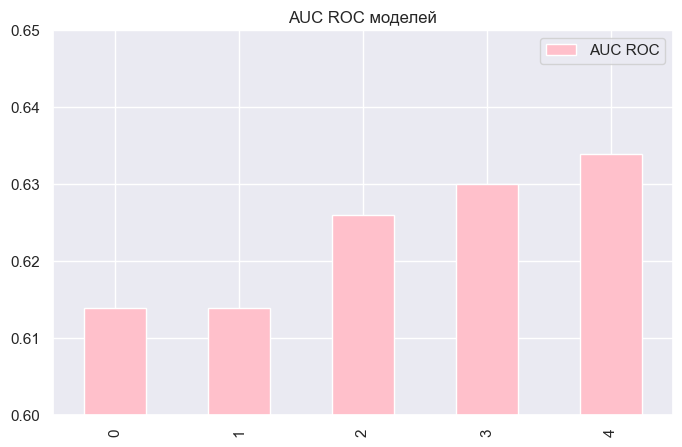

In [85]:
dt = [['tree_model_balanced',round((tree_model_balanced.best_score_),3) ], 
      ['dt', round((dt.best_score_),3)], 
      ['rf', round((rf.best_score_),3)],
      ['lgbm', round((lgbm.best_score_),3)],
      ['cb_model', round(pd.DataFrame(result['cv_results'])['test-AUC-mean'].max(),3)]]

v = pd.DataFrame(dt, columns=['model', 'AUC ROC'])
ax = v.plot.bar(ylim=(0.6, 0.65), title='AUC ROC моделей', figsize=(8, 5), color = 'pink',grid=True,)
v

Высоких результатов добится не удалось. Мы ориентировались на метрику AUC ROC, которая возрастала по мере построения моделей. Самый большой показатель у модели градиентного бустинга, построенной средствами библиотеки CatBoost  с передачей признаков без изменения и составляет 0.634. В указанной связи в качестве "лучшей из худших" выберем указанную модель для тестирования.

In [86]:
# Строим модель с подобранными гиперпараметрами
cb_model = CatBoostClassifier(depth = 6, l2_leaf_reg = 8, iterations = 200, learning_rate = 0.1)
cb_model.fit(train_features,train_target, cat_features=cat_features, verbose_eval = False)

#получаем предсказания
cb_model_pred = cb_model.predict(test_features)

#выводим метрику качества
print("AUC ROC:", round(roc_auc_score(test_target, (cb_model.predict_proba(test_features))[:, 1]),3))

AUC ROC: 0.636


В соответствии с условием проекта построим для нее график матрицы ошибок, PR-кривую и ROC-кривая

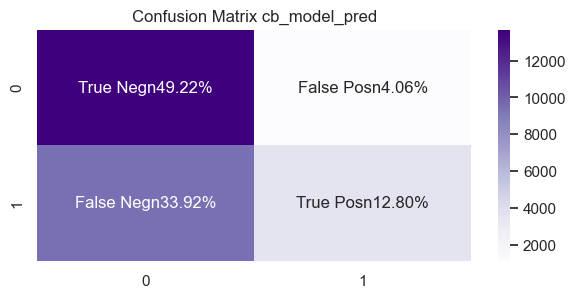

In [87]:
# Строим матрицу ошибок
cnf_matrix = confusion_matrix(test_target, cb_model_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_percentages = ["{0:.2%}".format(value) for value in
                     cnf_matrix.flatten()/np.sum(cnf_matrix)]

labels = [f"{v1}n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
plt.figure(figsize=(7, 3))
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Purples')
ax.set_title('Confusion Matrix cb_model_pred')
plt.show() 

На главной диагонали нашей матрицы ошибок располагаются правильные прогнозы модели: истинноположительные ответы составляют 49.22%, истинноотрицательные - 12.80%. Доля ложноположительных ответов 4.06% значительно ниже доли ложноотрицательных ответов, что не очень хорошо для нашего случая, т.к. ошибка неправильно предсказать риск лучше чем неправильно предсказать его отсутствие. Но у других моделей еще хуже.

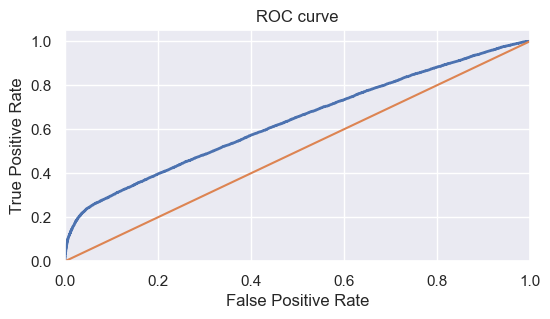

In [88]:
#код для ROC-кривой
sns.set(font_scale=1)
sns.set_color_codes("muted")
plt.figure(figsize=(6, 3))
ax = fpr, tpr, thresholds = roc_curve(test_target, cb_model.predict_proba(test_features)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

График ROC-кривой не очень, но все-таки возвышается над диагональю и хоть немного, но лучше случайной модели. 

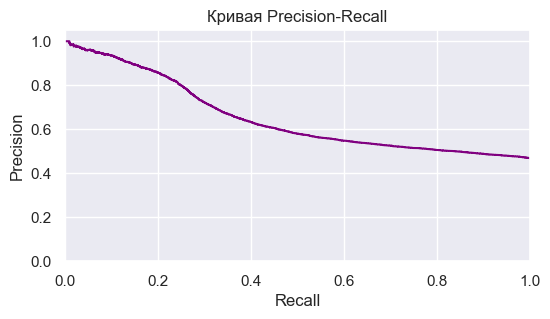

precision: 0.76
recall: 0.27
F1: 0.403


In [89]:
#код для  PR-кривой 
probabilities_valid = cb_model.predict_proba(test_features)
ax = precision, recall, thresholds = precision_recall_curve(test_target, probabilities_valid[:, 1])
plt.figure(figsize=(6, 3))
plt.step(recall, precision, where='post',color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

print("precision:", round((precision_score(test_target, cb_model_pred)),2))
print("recall:", round((recall_score(test_target,cb_model_pred)),2))
print("F1:", round ((f1_score(test_target, cb_model_pred)),3))

На графике Precision-Recall видно как по мере увеличения полноты предсказаний модели снижается ее точность, оптимальный показатель F1=0.403 достигается при значениях precision=0.76, recall=0.27


<b> Вывод:</b> При выборе модели, предсказывающей "рискованность" клиента каршеринговой компании пришлось остановиться на "лучшей из худших", поскольку у всех моделей невысокие метрики качества. Таковой оказалась модель  градиентного бустинга "cb_model", построенная средствами библиотеки CatBoost. Метрика AUC ROC на тестовой выборке незначительно больше показателя при обучении и составила  0.636 (при обучении AUC ROC: 0.634).
    
Будем исходить из того, что невысокий результат - тоже результат. Поищем его причины при анализе важности признаков, которые мы выбрали для построения модели.

## Анализ важности факторов ДТП

Для анализа важности факторов ДТП построим график

,feature,importance
0,party_sobriety,46.571697
1,vehicle_type,13.566284
2,distance,8.267109
3,county_city_location,6.325612
4,lighting,4.752908
5,collision_time,4.635459
6,vehicle_age,4.619896
7,control_device,3.106521
8,road_surface,2.888163
9,intersection,1.821221


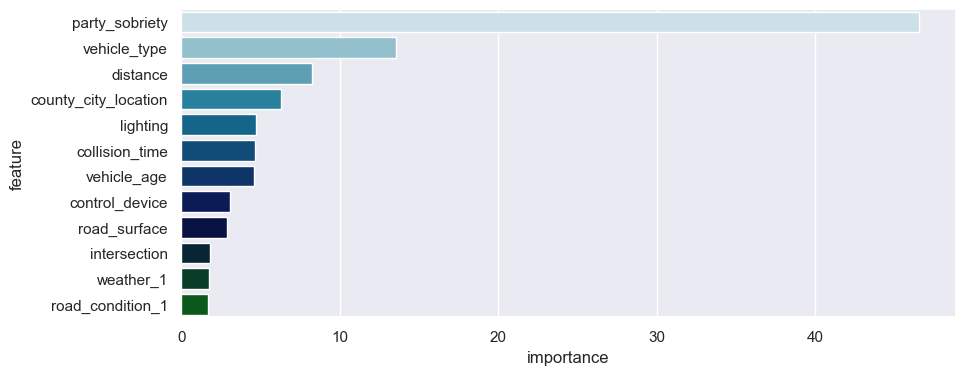

In [90]:
importances = cb_model.feature_importances_
feature_list = list(train_features.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

sns.set (font_scale= 1 )
plt.figure(figsize=[10,4])
ax = sns.barplot(x='importance', y="feature", data=feature_results, palette='ocean_r')
feature_results

Построенные мною модели не такие уж и бестолковые :) Самым значимым для нашей модели (46,6%) является признак "party_sobriety" (трезвость участника), что вполне закономерно, поскольку мы должны предсказать рискованность водителя, которая в первую очередь зависит от его личных качеств. 

Скорее всего по причине отсутствия в моем наборе признаков других данных, характеризующих личность водителя, у моделей низкие метрики. Но добавлять такие признаки как "party_drug_physical" (физическое состояние с учетом принятых лекарств) не имеет практического смысла, поскольку перед поездкой эти факты нигде и никак не зафиксируешь, они выясняются уже постфактум. Также не имеет смысла добавлять такие признаки как основной фактор аварии и вид нарушения ПДД, которых нет на стадии когда водитель сел за руль и выбрал маршрут движения. Да и измерение уровня трезвости при положительном показателе должно повлечь блокировку устройства управления автомобилем (такие способы уже есть).

Остальные признаки в сформированном датасете - внешние факторы, не зависящие от клиента и скорее предскажут факт ДТП, чем возможную виновность лица за рулем.

Значимость остальных признаков, начиная с vehicle_type(тип кузова автомобиля, 13.5%) стремительно снижается.Зависимость аварийности от типа кузова скорее всего связана с одинаковой распространенностью двух основных типов - купе и седан.

Расстояние от главной дороги действительно может повлиять на поведение водителя. Во-первых здесь действует общее правило приоритетности главной дороги, а во-вторых - чем менее значимая дорога, тем чаще встречается пренебрежение к правилам дорожного движения (в малонаселенном пункте чаще проедут на красный свет при отсутствии пешеходов).

На четвертом месте признак "county_city_location", что подтверждает факт деления на регионы с низкой и высокой аварийностью.

Возраст автомобиля, освещенность и время совершения аварии имеют примерно одинаковую значимость. Они не характеризуют непосредственно личность водителя и по-этому по нашей шкале их значение невелико - чуть более 4.5%. Вместе с тем, если предсказывать не поведение водителя, а факт вероятности ДТП, то эти факторы могут иметь большую значимость. 

Остальные признаки составляют 3% и меньше.

Для анализа выберем тот, что мне лично представляется наиболее интересным, всегда фиксируемым (с небольшим отклонением) перед началом поездки и не зависит от личности водителя - время совершения аварии.

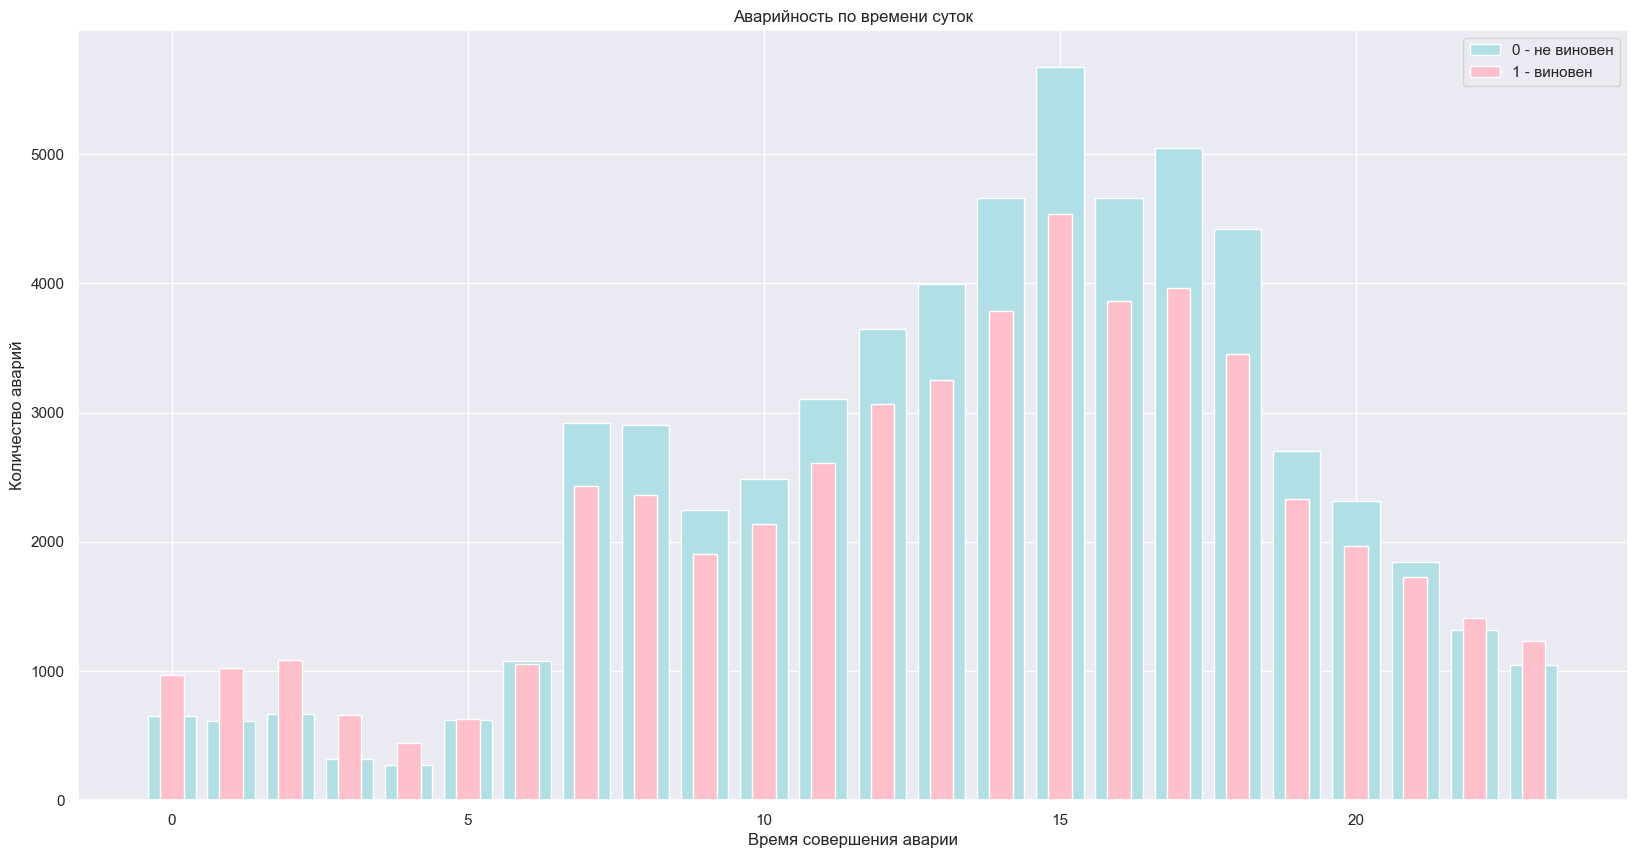

In [91]:
# группируем данные, строим график

m = data.query('at_fault == 0').pivot_table(index='collision_time' , values='at_fault', aggfunc='count')
mm = data.query('at_fault == 1').pivot_table(index='collision_time' , values='at_fault', aggfunc='count')

fig, ax = plt.subplots(figsize=[20,10])
plt.bar(x=m.index, height=m['at_fault'], color= 'powderblue', label='0 - не виновен')
plt.bar(x=mm.index, height=mm['at_fault'], color='pink', label='1 - виновен', width= 0.4)
plt.xlabel('Время совершения аварии')
plt.ylabel('Количество аварий')
ax.set_title('Аварийность по времени суток')
ax.legend()
plt.show()

На графике видно, что самая большая аварийность регистрируется с 13-00 до 18-00 часов. Пик приходится на 15-00. Наименее аварийным является время с 3-00 до 6-00 утра.

Вместе с тем, в период с 7-00 до 21-00 часов количество аварий, в которых клиенты каршеринговой компании не виновны, больше. А вот в ночное время - начиная с 22-00 и до 4-00 чаще виновниками ДТП оказываются клиенты компании. 

В указанной связи каршеринговой компании имеет смысл для клиентов, арендующих автомобили для краткосрочных поездок в ночное время предусмотреть повышенные тарифы. Либо стимулировать поездки в периоды с 9-00 до 10-00 и с 19-00 до 21-00 путем снижения тарифов, либо иных бонусов (например, оплата половины стоимости топлива), поскольку в эти часы аварийность с участием машин компании является средней и ниже средней и клиенты компании чаще оказываются невиновными в ДТП.

Кроме того, для решения задачи предсказания "рискованности" водителя имеет смысл использовать данные о результатах предыдущих поездок водителей (попадал/не попадал в аварии). Наверняка они в базе данных каршеринговой компании есть, да и потенциальные клиенты как правило выбирают одну и ту же компанию.

Кроме того, имеет смысл для предсказания "рискованности" водителя в качестве признака учитывать его водительский стаж, сведения о котором можно взять из водительского удостоверения, наличие которого необходимо для любой поездки. В сочетании с данными о возрасте потенциального водителя (это тоже есть в водительских правах) по этим признакам до начала поездки модель лучше спрогнозирует насколько хорош окажется водитель.

## Выводы


<b> Итоговый вывод:</b>
По заказу каршеринговой компании построена система, оценивающая риск ДТП по выбранному маршруту движения. Под риском заказчик определил вероятность ДТП с любым повреждением транспортного средства (как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска, если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту).

Из данных, предоставленных заказчиком сформирован датасет, который после предварительной обработки данных насчитывает 13 столбцов и 111130 объектов. Целевой признак классицирован по бинарному типу, в нем отмечается незначительный дисбаланс классов. Также имеется 3 количественных признака, два категориальных "county_city_location" и "intersection" переведены в числовые данные, остальные признаки категориальные.

Предварительная обработка данных включала удаление пропусков, категоризацию значений в признаках 'party_sobriety', 'lighting', 'control_device'. Данные о номере региона ДТП, времени происшествия, аварийности перекрестков, состоянии дороги, расстоянии от главной дороги, типе кузова, состоянии проезжей части, оставлены без изменения.

В стадии подготовки признаков для построения модели машинного обучения данные разделены на выборки для обучения и тестирования в соотношении 3:1, дальнейшая их обработка производилась раздельно; категориальные признаки, представленные текстом, кодированы техникой OHE; количественные признаки и категориальные, переведенные в числовые данные, стандартизированы.

Построены несколько моделей машинного обучения с перебором гиперпараметров для наилучшего показателя метрики качества AUC-ROC:   
два "Дерева решений" (с применением в качестве борьбы с дисбалансом классов целевого признака аргумента class_weight='balanced' и функции Downsampling), "Случайный лес" и модель градиентного бустинга библиотеки lightgbm также с применением функции Downsampling, модель градиентного бустинга библиотеки catboost на изначальных признаках. Модели, обученные на данных, для которых в качестве больбы с дисбалансом классов применена функция Downsampling, построены посредством pipeline.

Для выбора оптимальной модели по каждой из них вывели лучшие гиперпараметры и метрику качества, переданную в scoring (AUC ROC), на которую ориентировались при подборе гиперпараметров. Перебор гиперпараметров осуществлялся посредством модуля GridSearchCV
 
Значительных метрик добиться не удалось, самой лучшей (из того что получилось) оказалась модель градиентного бустинга "cb_model", построенная средствами библиотеки CatBoost с метриками AUC ROC = 0.634.
    
Анализом важности признаком установлено, что самым значимым для нашей модели (46%) является признак "party_sobriety" (трезвость участника), что вполне закономерно, поскольку мы должны предсказать рискованность водителя, которая в первую очередь зависит от его личных качеств. 

Скорее всего по причине отсутствия в наборе признаков других данных, характеризующих личность водителя, у моделей низкие метрики. Но добавлять такие признаки как "party_drug_physical" (физическое состояние с учетом принятых лекарств) не имеет практического смысла, поскольку перед поездкой эти факты нигде и никак не зафиксируешь, они выясняются уже постфактум. Также не имеет смысла добавлять такие признаки как основной фактор аварии и вид нарушения ПДД, которых нет на стадии когда водитель сел за руль и выбрал маршрут движения.

Значимость остальных признаков, начиная с vehicle_type стремительно снижается, что не удивительно, поскольку они характеризуют внешние факторы аварийности, не зависящие от водителя, а по заданию заказчика мы ориентировались на виновность водителя.  
    
Более других проанализирован признак collision_time (время совершения ДТП). Установлено, что самая большая аварийность регистрируется с 13-00 до 18-00 часов. Пик приходится на 15-00. Наименее аварийным является время с 3-00 до 6-00 утра. Вместе с тем, в период с 7-00 до 21-00 часов количество аварий, в которых клиенты каршеринговой компании не виновны, больше. А вот в ночное время - начиная с 22-00 и до 4-00 чаще виновниками ДТП оказываются клиенты компании.

В указанной связи исходя из имеющихся данных предложения бизнесу можно сформулировать так:    
- для клиентов, арендующих автомобили для краткосрочных поездок в ночное время возможно предусмотреть повышенные тарифы, либо стимулировать поездки в периоды с 9-00 до 10-00 и с 19-00 до 21-00 путем снижения тарифов, или иных бонусов (например, оплата половины стоимости топлива), поскольку в эти часы аварийность с участием машин компании является средней и ниже средней и клиенты компании чаще оказываются невиновными в ДТП.
    
Для усовершенствования модели машинного обучения по предсказанию "рискованности" водителя заказчику целесообразно саккумулировать данные, характеризующие личность водителя, которые известны до совершения поездки, а не после (типа употребление лекарств, или вид ДТП) :
-  о результатах предыдущих поездок водителей (попадал/не попадал в аварии), которые скорее всего в базе данных каршеринговой компании есть (да и потенциальные клиенты как правило выбирают одну и ту же компанию);
- о водительском стаже (есть в водительском удостоверении);
- о возрасте потенциального водителя (также есть в водительских правах).

Указанные данные доступны, характеризуют личность водителя и в своей совокупности должны улучшить качество предсказаний именно "рискованности" потенциального водителя до начала поездки, как это необходимо заказчику. 